In [24]:
import pandas as pd
import numpy as np
from numpy import diff

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd
import math

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from datetime import datetime, timezone

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})


# set the font globally
# plt.rcParams.update({'font.family':'Helvetica'})

In [25]:
# data = pd.read_csv('sum_with_2005_eqs.csv', header = 'infer')
data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUeq_data.csv", header = 'infer')
# data.dtypes

In [26]:
# data = data[(data['MW'] >= 5.1)]

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

### Megathrust and Deep slab

In [27]:
########## Sumatra-Andaman MegaThrust for a Mw range above Mc
data_mt = data.loc[data['CLASS'] == 'MTHRUST']
data_mt = data_mt[(data_mt['LAT'] <= 15) & (data_mt['LAT'] >= -3)]
data_depth = data_mt[(data_mt['DEPTH'] < 70)]

mt_exp = np.asarray(data_mt['EX'])
mt_mo = np.asarray(data_mt['MO'])
mt_time = np.asarray(data_mt['YEARS'])
mt_energy = mt_mo*np.power(10., mt_exp)
mt_energy_cum = np.cumsum(mt_energy)
# mt_strain = np.sqrt(mt_energy)
# mt_strain_cum = np.cumsum(mt_strain)


######## Sumatra-Andaman MegaThrust for >= Mc
data_mt1 = data_depth[(data_depth['MW'] >= 5.1)]
mt1_exp = np.asarray(data_mt1['EX'])
mt1_mo = np.asarray(data_mt1['MO'])
mt1_time = np.asarray(data_mt1['YEARS'])
mt1_energy = mt1_mo*np.power(10., mt1_exp)
mt1_energy_cum = np.cumsum(mt1_energy)


# ######## Java MegaThrust for >= Mc
# data_Jmt = data.loc[data['CLASS'] == 'MTHRUST']
# data_Jmt = data_Jmt[(data_Jmt['LON'] >= 106)]
# data_depth = data_Jmt[(data_Jmt['DEPTH'] < 40)]
# data_Jmt = data_depth[(data_depth['MW'] >= 5.1)] #Mc
# Jmt_exp = np.asarray(data_Jmt['EX'])
# Jmt_mo = np.asarray(data_Jmt['MO'])
# Jmt_time = np.asarray(data_Jmt['YEARS'])
# Jmt_energy = Jmt_mo*np.power(10., Jmt_exp)
# Jmt_energy_cum = np.cumsum(Jmt_energy)


# Deep Java slab for Mw < 5.5, 5 years predates
data_lessM5 = data[(data['DEPTH'] > 70)]
data_M5 = data_lessM5.loc[data_lessM5['CLASS'] == 'DGOING']
# data_M5 = data_M5[(data_M5['MW'] >= 5.5) & (data_M5['MW'] <= 7.5)]
data_long = data_M5[(data_M5['LAT'] <= -2)]

long_lessM5_exp = np.asarray(data_long['EX'])
long_lessM5_mo = np.asarray(data_long['MO'])
long_lessM5_time = np.asarray(data_long['YEARS'])
long_lessM5_energy = long_lessM5_mo*np.power(10., long_lessM5_exp)
long_lessM5_energy_cum = np.cumsum(long_lessM5_energy)

In [28]:
data_test = data[(data['MW'] >= 6.5)]
data_test = data_test[(data_test['LAT'] >= -5)] # SUM-AND
data_test = data_test.loc[data_test['CLASS'] == 'MTHRUST']

# print(data_test[['LAT','DEPTH', 'DATE', 'MW', 'YEARS', 'TYPE', 'CLASS']])

### Above 80 km slab seismicity

In [29]:
data_dw = data[(data['DEPTH'] > 70) &
               (data['CLASS'] == 'DGOING') &
              (data['MW'] >= 5.1)]
# data_dw = data_great80depth.loc[data_great80depth['CLASS'] == 'DGOING']
# data_dw = data_dw[data_dw['MW'] < 6.5]

# Java slab
data_long = data_dw[(data_dw['LAT'] <= -3)]
# data_long = data_long[(data_long['DATE'] > '01-01-1984') & (data_long['DATE'] < '26-11-2004')]

long_great80_exp = np.asarray(data_long['EX'])
long_great80_mo = np.asarray(data_long['MO'])
long_great80_time = np.asarray(data_long['YEARS'])
long_great80_energy = long_great80_mo*np.power(10., long_great80_exp)
long_great80_energy_cum = np.cumsum(long_great80_energy)

In [30]:
# short Sumatra-andaman slab
# data_dw = data_dw[data_dw['MW'] < 5.5]
data_sumatra = data_dw[(data_dw['LAT'] >= -3) & (data_dw['LAT'] <= 14)]

sumatraslab_great80_exp = np.asarray(data_sumatra['EX'])
sumatraslab_great80_mo = np.asarray(data_sumatra['MO'])
sumatraslab_great80_time = np.asarray(data_sumatra['YEARS'])
sumatraslab_great80_energy = sumatraslab_great80_mo*np.power(10., sumatraslab_great80_exp)
sumatraslab_great80_energy_cum = np.cumsum(sumatraslab_great80_energy)

In [31]:
# # short Andaman slab
# # data_dw = data_dw[data_dw['MW'] < 5.8]
# data_andaman = data_dw[(data_dw['LAT'] > 6) & (data_dw['LAT'] < 15)]

# andamanslab_great80_exp = np.asarray(data_andaman['EX'])
# andamanslab_great80_mo = np.asarray(data_andaman['MO'])
# andamanslab_great80_time = np.asarray(data_andaman['YEARS'])
# andamanslab_great80_energy = andamanslab_great80_mo*np.power(10., andamanslab_great80_exp)
# andamanslab_great80_energy_cum = np.cumsum(andamanslab_great80_energy)

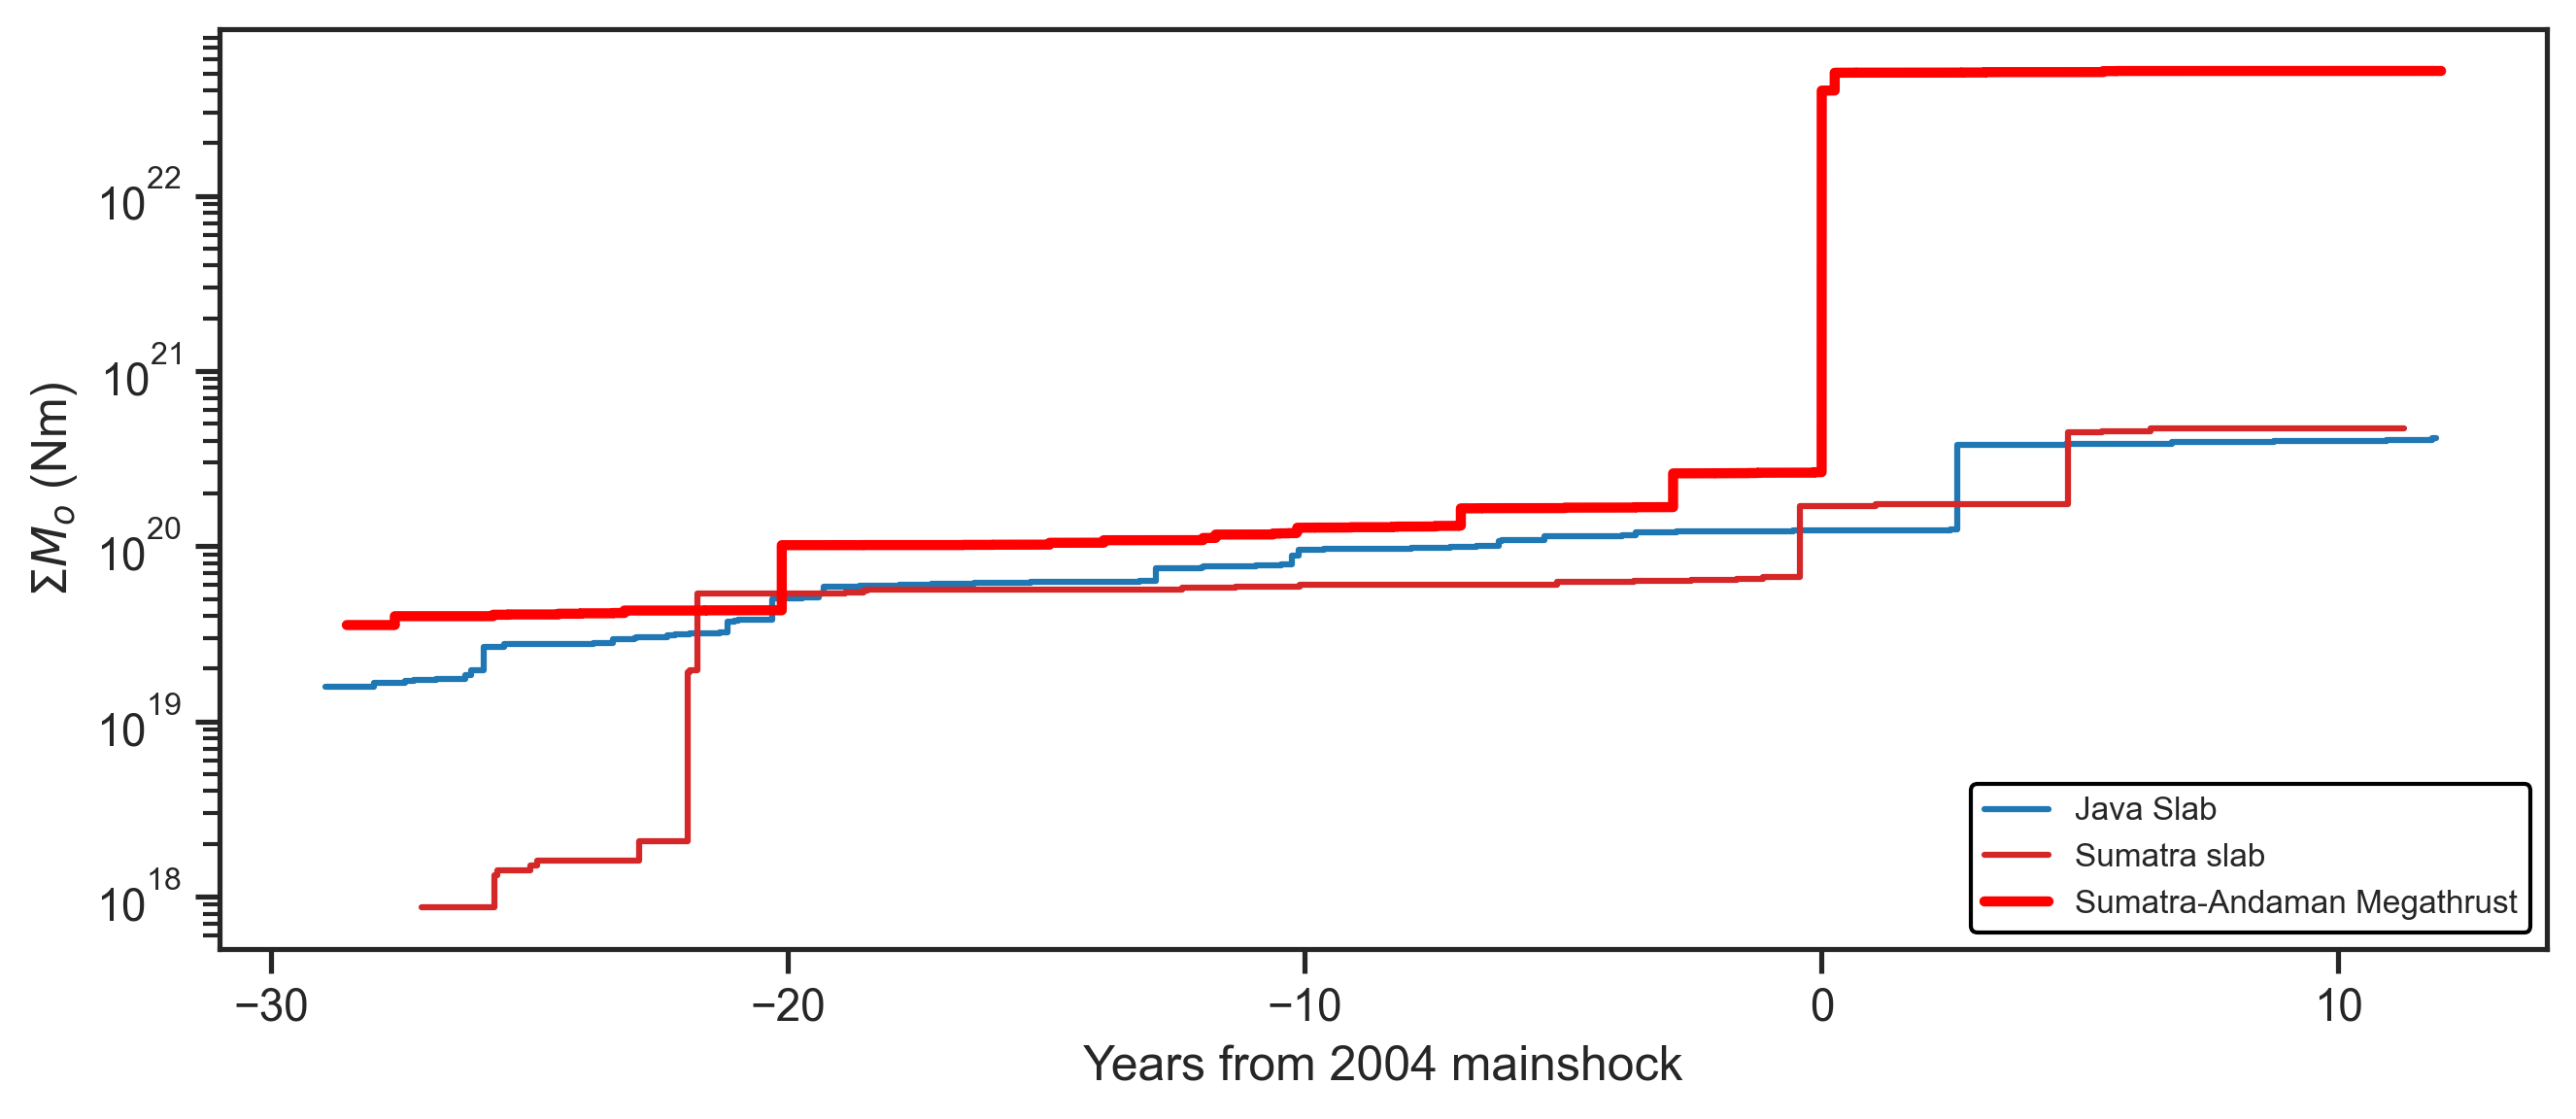

In [32]:
figsize = (9,4)
dpi=300
width = 1
# xlimit = [-4, 4]
# ylimit = [0e18, 3e18]

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= False)

################################
fig1=ax


# fig1.axvline(x= 0, color="black", label='2004 Mainshock', lw=0.8, ls='--', alpha=0.8)

lw = 8
alpha=0.3
# fig1.axvline(x= 0, color="gray", lw=1, ls='-', alpha=0.7)
# bands left to right
# fig1.axvline(x=-20.2, color='orange', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-12.8, color='maroon', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-10, color='tab:purple', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-7, color='cyan', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-3.4, color='red', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=0, color='yellow', lw=lw, ls='-', alpha=0.7)
# fig1.axvline(x=2.8, color='grey', lw=lw, ls='-', alpha=0.4)


#### long slab plot
new_t = []
for i, s in enumerate(long_great80_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(long_great80_energy_cum):
    if i != 0:
        new_y.append(long_great80_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 4,
          linewidth=1.5, color = 'tab:blue',
          alpha=1, label='Java Slab')

# ###### Java megathrust ############
# new_t = []
# for i, s in enumerate(Jmt_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(Jmt_energy_cum):
#     if i != 0:
#         new_y.append(Jmt_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig1.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=2.5, color = 'tab:blue',
#           alpha=1, label='Java Megathrust',
#          mfc = 'white',mew = 1, lw = 1)
# fig1.yaxis.set_ticks_position("right")


###### Sumatra-andaman slab plot
new_t = []
for i, s in enumerate(sumatraslab_great80_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(sumatraslab_great80_energy_cum):
    if i != 0:
        new_y.append(sumatraslab_great80_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = 'tab:red',
          alpha=1, label='Sumatra slab')

# ###### Andaman slab plot
# new_t = []
# for i, s in enumerate(andamanslab_great80_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(andamanslab_great80_energy_cum):
#     if i != 0:
#         new_y.append(andamanslab_great80_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig1.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=1.5, color = 'green',
#           alpha=1, label='Andaman slab',
#           mfc = 'white',mew = 1, lw = 1)


###### Sumatra megathrust
new_t = []
for i, s in enumerate(mt_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(mt_energy_cum):
    if i != 0:
        new_y.append(mt_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=2.5, color = 'red',
          alpha=1, label='Sumatra-Andaman Megathrust')
#####
# fig1.set_xlim([-21.7, 10])
# fig1.set_ylim([1e16, 1e23])

fig1.set_yscale('log')

fig1.set_xlabel('Years from 2004 mainshock')
fig1.set_ylabel(r'$\Sigma M_o$ (Nm)')
# fig1.yaxis.set_ticks_position("right")


#####################################################
# fig2=ax[1]

# # fig1.axvline(x= 0, color="gray", lw=1, ls='-', alpha=0.7)
# fig2.axvline(x= 0, color="gray", label='2004 Mainshock', lw=1, ls='-', alpha=0.7)
# fig2.axvline(x=-0.25, color='yellow', lw=15, ls='-', alpha=0.7)
# fig2.axvline(x=2.8, color='grey', lw=15, ls='-', alpha=0.4)

# #### long slab plot
# new_t = []
# for i, s in enumerate(long_lessM5_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(long_lessM5_energy_cum):
#     if i != 0:
#         new_y.append(long_lessM5_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig2.plot(new_t, new_y, '-', markersize = 4,
#           linewidth=1.5, color = 'tab:blue',
#           alpha=1, label='Java Slab',
#          mfc = 'white', mew = 1, lw = 1)

# # ###### Sumatra slab plot
# # new_t = []
# # for i, s in enumerate(sumatraslab_great80_time):
# #     new_t.append(s)
# #     if i != 0:
# #         new_t.append(s)
    
# # # the y value
# # new_y = []
# # for i, s in enumerate(sumatraslab_great80_energy_cum):
# #     if i != 0:
# #         new_y.append(sumatraslab_great80_energy_cum[i-1])
# #         new_y.append(s)
# #     else:
# #         new_y.append(s)

# # fig2.plot(new_t, new_y, '-', markersize = 5,
# #           linewidth=1.5, color = 'tab:red',
# #           alpha=1, label='Sumatra slab',
# #           mfc = 'white',mew = 1, lw = 1)

# # ###### Andaman slab plot
# # new_t = []
# # for i, s in enumerate(andamanslab_great80_time):
# #     new_t.append(s)
# #     if i != 0:
# #         new_t.append(s)
    
# # # the y value
# # new_y = []
# # for i, s in enumerate(andamanslab_great80_energy_cum):
# #     if i != 0:
# #         new_y.append(andamanslab_great80_energy_cum[i-1])
# #         new_y.append(s)
# #     else:
# #         new_y.append(s)

# # fig2.plot(new_t, new_y, '-', markersize = 5,
# #           linewidth=1.5, color = 'green',
# #           alpha=1, label='Andaman slab',
# #           mfc = 'white',mew = 1, lw = 1)

# ###### Sumatra megathrust Mw < 5.0
# new_t = []
# for i, s in enumerate(mt_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(mt_energy_cum):
#     if i != 0:
#         new_y.append(mt_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig2.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=2.5, color = 'red',
#           alpha=1, label='Sumatra Megathrust',
#          mfc = 'white',mew = 1, lw = 1)
# ######

# # fig2.plot(mt1_time, mt1_energy_cum, '-', markersize = 4,
# #           linewidth=2.5, color = 'red',
# #           alpha=1, label='Sumatra Megathrust',
# #          mfc = 'white', mew = 1, lw = 1)


# fig2.set_xlim([-5, 5])
# # fig2.set_ylim([1e16, 5e18])

# fig2.set_yscale('log')

# fig2.set_xlabel('Years from 2004 mainshock')
# # fig2.set_ylabel(r'$\Sigma M_o$ (N-m)')

# fig2.yaxis.set_ticks_position("right")


# fs=10
# ### annotate
# fig2.annotate('$M_w$ 5.8 (6 June) \n (Down-dip extension)', ha='center', color='tab:blue',
#               xy=(-0.6, 1.12e20),
#               xytext=(-2.8, 4e19), fontsize=fs,
#             arrowprops=dict(facecolor='tab:blue',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='tab:blue'))

# fig2.annotate('$M_w$ 7.3 (25 July) \n (Down-dip extension)', ha='center', color='tab:blue',
#               xy=(-0.4, 1.5e20),
#               xytext=(2.5, 5e19), fontsize=fs,
#             arrowprops=dict(facecolor='tab:blue',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='tab:blue'))

# fig1.annotate('2004 mainshock', color='red',
#               xy=(-1, 2e21),
#               xytext=(-14, 2e22), fontsize=fs,
#             arrowprops=dict(facecolor='red',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='red'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")


# x0, xmax = fig1.set_xlim()
# y0, ymax = fig1.set_ylim()
# data_width = xmax - x0
# data_height = ymax - y0
# # fig1.text(x0 + data_width*0.01, y0 + data_height * 1.4, 'a.', weight='bold', fontsize=14)
# fig1.text(x0 + data_width*0.07, y0 + data_height * 0.0000002, '$M_w$ ≥ 5.1', fontsize=fs)
# # fig1.text(x0 + data_width*0.07, y0 + data_height * 0.0000001, '$Depth$ > 80 km', fontsize=fs)

# x0, xmax = fig2.set_xlim()
# y0, ymax = fig2.set_ylim()
# data_width = xmax - x0
# data_height = ymax - y0
# fig2.text(x0 + data_width*0.01, y0 + data_height * 1.1, 'b.', weight='bold', fontsize=14)
# fig2.text(x0 + data_width*0.1, y0 + data_height * 0.002, '$M_w$ 5.5-7.5', fontsize=fs)
# # fig2.text(x0 + data_width*0.6, y0 + data_height * 0.0008, '$Depth$ > 80 km', fontsize=fs)


fig1.legend(loc = 'lower right',
            fontsize = 8,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=0.9)

plt.tight_layout()

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/Corr_T-Mo.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

TypeError: Got both 'linewidth' and 'lw', which are aliases of one another

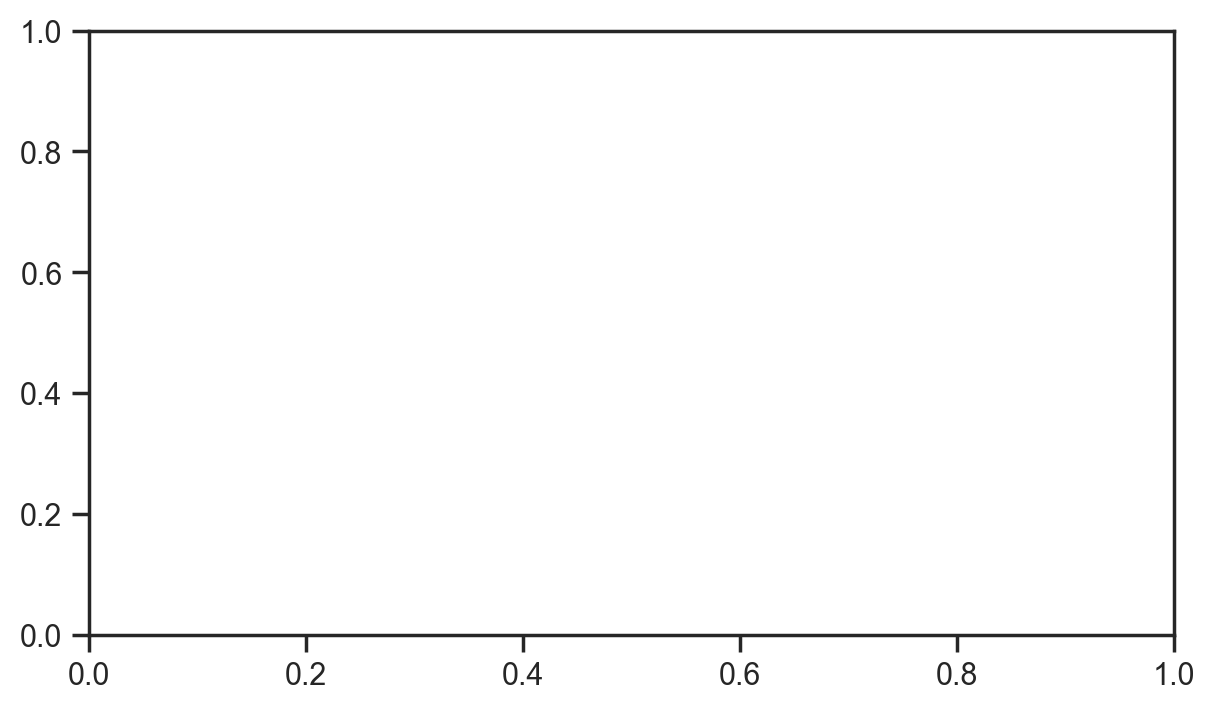

In [33]:
data_slab = data[(data['P(km)'] > 0) & (data['DEPTH'] >= 70) & (data['MW'] >= 5.1)] # only in the subducting slab at < 300 km
data_DW = data_slab.loc[data['CLASS'] == 'DGOING']

data_T_DW = data_DW.loc[data_DW['TYPE'] == 'THRUST']
data_SS_DW = data_DW.loc[data_DW['TYPE'] == 'SS']
data_N_DW = data_DW.loc[data_DW['TYPE'] == 'NORM']

figsize = (7,4)
dpi=200
width = 1
# xlimit = [-4, 4]
# ylimit = [0e18, 3e18]

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= False)

################################
fig1=ax


# fig1.axvline(x= 0, color="black", label='2004 Mainshock', lw=0.8, ls='--', alpha=0.8)

lw = 10
alpha=0.4
fig1.axvline(x= 0, color="gray", lw=1, ls='-', alpha=0.7)
# bands left to right

# exact locations for Mw ≥ 6.1
# fig1.axvline(x=-20.12, color='orange', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-12.8, color='maroon', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-10.16, color='tab:purple', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-6.98, color='cyan', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-2.87, color='red', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=0, color='gold', lw=lw, ls='-', alpha=0.6)
# fig1.axvline(x=2.95, color='grey', lw=lw, ls='-', alpha=alpha)



###### Sumatra-Andaman megathrust
new_t = []
for i, s in enumerate(mt_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(mt_energy_cum):
    if i != 0:
        new_y.append(mt_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=2.5, color = 'red',
          alpha=1, label='SUM-AND Megathrust',
         mfc = 'white',mew = 1, lw = 1)

###### Sumatra-andaman slab plot
new_t = []
for i, s in enumerate(sumatraslab_great80_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(sumatraslab_great80_energy_cum):
    if i != 0:
        new_y.append(sumatraslab_great80_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = 'red',
          alpha=0.8, label='SUM-AND slab',
          mfc = 'white',mew = 1, lw = 1)

# ###### Java megathrust ############
# new_t = []
# for i, s in enumerate(Jmt_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(Jmt_energy_cum):
#     if i != 0:
#         new_y.append(Jmt_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig1.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=2.5, color = 'tab:blue',
#           alpha=0.9, label='Java Megathrust',
#          mfc = 'white',mew = 1, lw = 1)
# fig1.yaxis.set_ticks_position("right")

#### long slab plot
new_t = []
for i, s in enumerate(long_great80_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(long_great80_energy_cum):
    if i != 0:
        new_y.append(long_great80_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 4,
          linewidth=1.5, color = 'tab:blue',
          alpha=1, label='Long slab',
         mfc = 'white', mew = 1, lw = 1)

###### Andaman slab plot
# new_t = []
# for i, s in enumerate(andamanslab_great80_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(andamanslab_great80_energy_cum):
#     if i != 0:
#         new_y.append(andamanslab_great80_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig1.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=1.5, color = 'green',
#           alpha=0.6, label='Andaman slab',
#           mfc = 'white',mew = 1, lw = 1)



#####
fig1.set_xlim([-25, 10])
fig1.set_ylim([1e18, 1e23])

fig1.set_yscale('log')

fig1.set_xlabel('Years from 2004 mainshock')
fig1.set_ylabel(r'$\Sigma M_o$ (Nm)')
# fig1.yaxis.set_ticks_position("right")


# fig1.annotate('$M_w9.0$ (2004)', color='black',
#               xy=(-0.05, 2e21),
#               xytext=(-10, 0.2e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")

# fig1.annotate('$M_w8.5$ (2005)', color='black',
#               xy=(0.35, 4.3e22),
#               xytext=(-10, 0.99e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")


# fig1.annotate('$M_w8.5$ (2007)', color='black',
#               xy=(2.9, 4.5e22),
#               xytext=(3.5, 0.5e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")

# fig1.annotate('Down-dip extension', color='black',
#               xy=(-0.6, 1e20),
#               xytext=(-10, 1e19), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")


fig1.legend(loc = 'lower right',
            fontsize = 8,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=0.9)

plt.tight_layout()

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/TS_Mo.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

In [ ]:
# fig1.axvline(x=-20.12, color='orange', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-11.97, color='maroon', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-10.16, color='tab:purple', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-6.98, color='cyan', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-2.87, color='red', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=0, color='gold', lw=lw, ls='-', alpha=0.6)
# fig1.axvline(x=2.95, color='grey', lw=lw, ls='-', alpha=alpha)

In [ ]:
# -20.2
eq1 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) &
        (data['MW'] >= 6) & (data['MW'] < 10) &
           (data['CLASS'] == 'MTHRUST') &
          (data['YEARS'] < 0)]

print(eq1[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# -12.8
eq2 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -14) & (data['YEARS'] <= -11)]

print(eq2[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# -10
eq3 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -10.5) & (data['YEARS'] <= -9.5)]

print(eq3[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# -7
eq4 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -7.5) & (data['YEARS'] <= -6.5)]

print(eq4[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# -3.4
eq5 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -3) & (data['YEARS'] <= -2)]

print(eq5[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# 0
eq6 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -1) & (data['LAT'] <= 6) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -1) & (data['YEARS'] < 0)]

print(eq6[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

In [ ]:
# 2.8
eq6 = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -5) & (data['LAT'] <= -4) & (data['CLASS'] == 'MTHRUST') &
        (data['YEARS'] >= -5) & (data['YEARS'] <= -3)]

print(eq6[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

# Cumulative number of events verses time

In [ ]:
data_Java = data[(data['DEPTH'] > 80) &
               (data['CLASS'] == 'DGOING') &
              (data['MW'] >= 1) &
              (data['LAT'] <= -2)]

data_SUM = data[(data['DEPTH'] < 50) &
               (data['CLASS'] == 'MTHRUST') &
              (data['MW'] >= 1) &
              (data['LAT'] >= -6) & (data['LAT'] <= 6)]

In [ ]:
count_java = data_Java["YEARS"]
count_sum = data_SUM["YEARS"]
# count_and = data_AND["YEARS"]

num_event_java = len(count_java) 
print('Total number of events in Java:', num_event_java)

num_event_sum = len(count_sum) 
print('Total number of events in Sumatra:', num_event_sum)

# num_event_and = len(count_and)
# print('Total number of events in Andaman:', num_event_and)

In [ ]:
figsize = (8,3)
dpi=200
lw=1.5
bins=300
alpha=0.7

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= True)
fig=ax

# normalised number of events
fig.hist(count_java,  bins=bins,  histtype='step', cumulative=True, color='tab:blue', linewidth=2, label='Java')
fig.hist(count_sum,  bins=bins,  histtype='step', cumulative=True, color='tab:red', linewidth=2, label='Sumatra')
# fig.hist(count_and,  bins=bins,  histtype='step', cumulative=True, color='tab:green', linewidth=2, label='Andaman')

fig.set_ylabel('Cumulative Number \n of Events')
fig.set_xlabel('years')

fig.set_xlim([-25, 10])
fig.set_xlim([-5, 5])

# fig.legend(loc = 'upper left',
#             fontsize = 8,
#             framealpha=1,
#            facecolor='white',
#             edgecolor="grey",
#             markerscale=0.1)

fig.axvline(x=-20.2, color='orange', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=-12.8, color='maroon', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=-10, color='tab:purple', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=-7, color='cyan', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=-3.4, color='red', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=0, color='gold', lw=lw, ls='--', alpha=alpha)
fig.axvline(x=2.8, color='grey', lw=lw, ls='--', alpha=alpha)

fig.axvline(x=0.25, color='blue', lw=lw, ls='--', alpha=alpha) # 2005 event

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/cum_events.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

In [ ]:
# jovian.commit()